In [98]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [99]:
# Import data as one fully merged table
url = "https://drive.google.com/file/d/1qVCY89oBC2chFGAZdrx7djTAyuuhKtKf/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
complete_df = pd.read_csv(path)

# Have a Look at the Data


In [100]:
complete = complete_df.copy()
complete.head(1)

,id_order,prod_qty,sku,unit_price,date,order_total,total_paid,state,name,price,short,long,category,discount,discount_percentage,has_discount
0,300713,1,OTT0133,19.99,2017-01-02,54.99,54.99,Completed,Otterbox iPhone Case Symmetry 2.0 SE / 5s / 5 ...,34.99,OTT,Otterbox,iphonecase,15.0,42.87,True


In [101]:
# Arrange the columns in a logical order
complete = (complete.loc[:,
              ["date",
              "sku",
              "name",
              "category",
              "price",
              "unit_price",
              "has_discount",
              "discount_percentage",
              "prod_qty",
              "order_total",
              "total_paid",
              "id_order"]
                      ]
          )

In [102]:
complete.head(1)

,date,sku,name,category,price,unit_price,has_discount,discount_percentage,prod_qty,order_total,total_paid,id_order
0,2017-01-02,OTT0133,Otterbox iPhone Case Symmetry 2.0 SE / 5s / 5 ...,iphonecase,34.99,19.99,True,42.87,1,54.99,54.99,300713


In [103]:
complete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64830 entries, 0 to 64829
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 64830 non-null  object 
 1   sku                  64830 non-null  object 
 2   name                 64830 non-null  object 
 3   category             64811 non-null  object 
 4   price                64830 non-null  float64
 5   unit_price           64830 non-null  float64
 6   has_discount         64830 non-null  bool   
 7   discount_percentage  64830 non-null  float64
 8   prod_qty             64830 non-null  int64  
 9   order_total          64830 non-null  float64
 10  total_paid           64830 non-null  float64
 11  id_order             64830 non-null  int64  
dtypes: bool(1), float64(5), int64(2), object(4)
memory usage: 5.5+ MB


In [104]:
# Transform column 'date' to type datetime
complete["date"] = pd.to_datetime(complete["date"])

## Visualization of Product Orders Based on Discount Percentage Categories

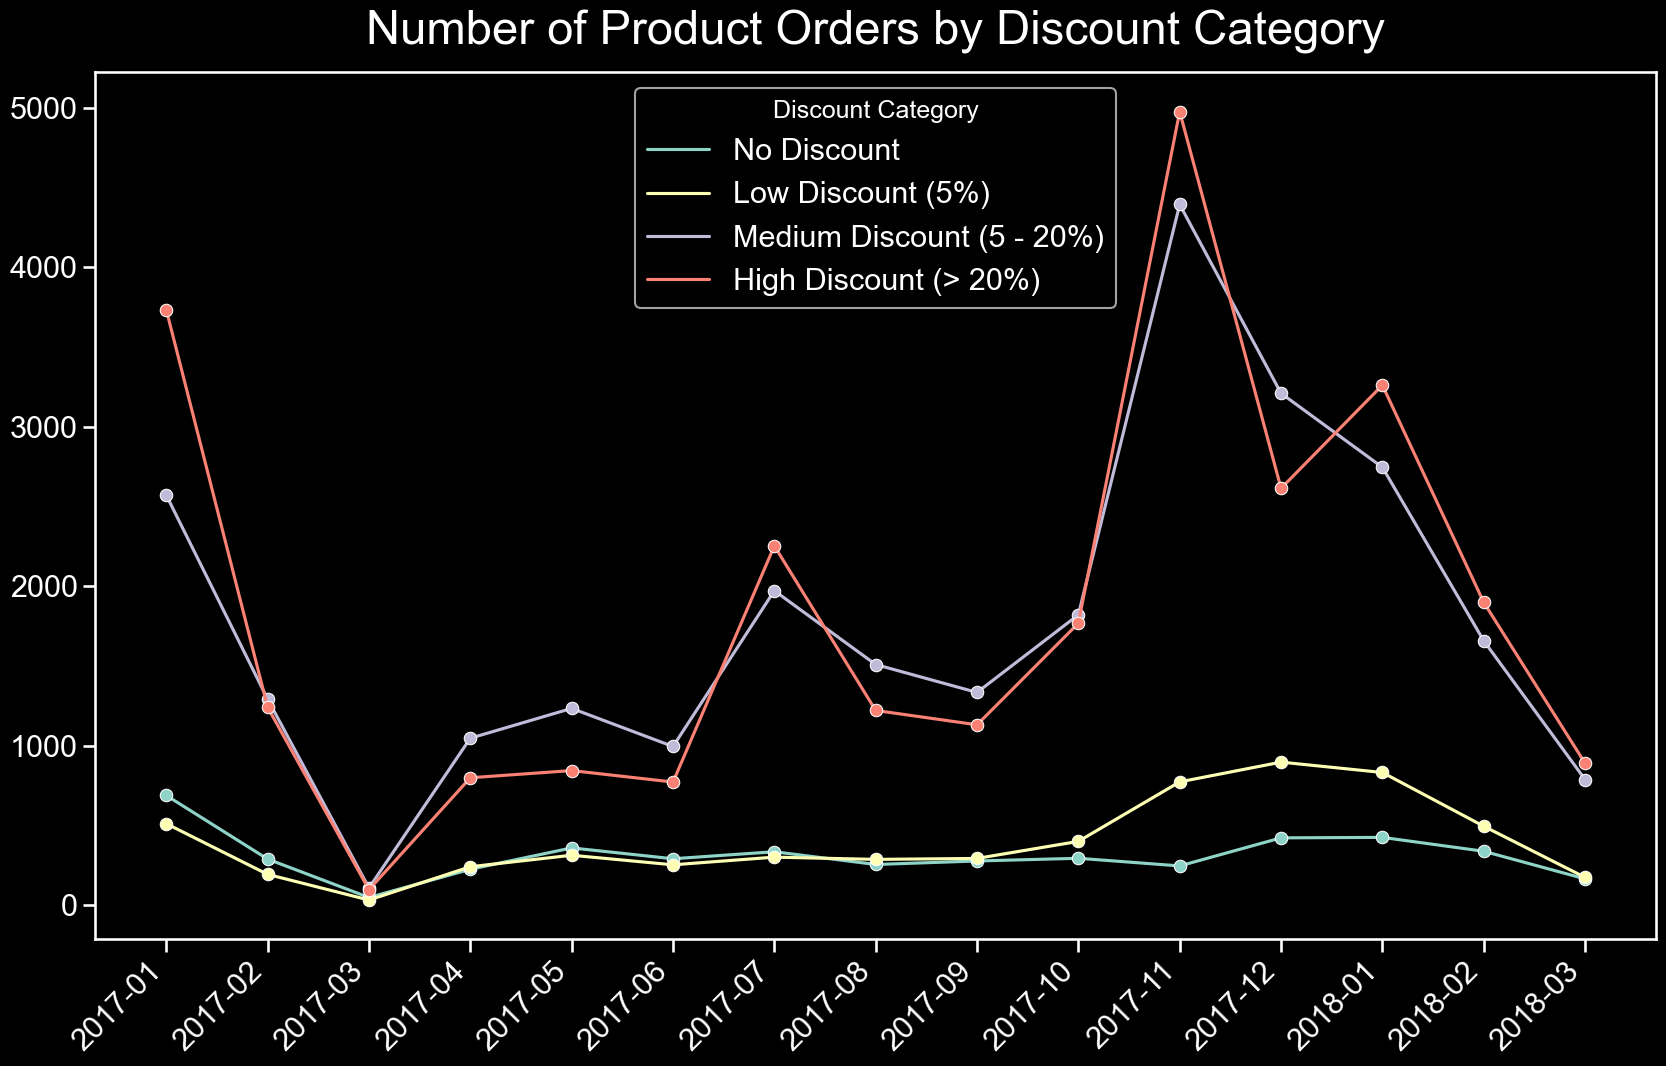

In [105]:
# Categorize discounts into high, medium, low
high_discount_threshold = 20
low_discount_threshold = 5

# Create categories and convert the column to categorical
categories = pd.cut(complete['discount_percentage'],
                    bins=[-float('inf'), 0, low_discount_threshold, high_discount_threshold, float('inf')],
                    labels=['No Discount', 'Low Discount (5%)', 'Medium Discount (5 - 20%)', 'High Discount (> 20%)'])

# Assign the categories to the column
complete['discount_category'] = pd.Categorical(categories,
                                              categories=['No Discount', 'Low Discount (5%)', 'Medium Discount (5 - 20%)', 'High Discount (> 20%)'],
                                              ordered=True)

# Extract month and year from the date
complete['month_year'] = complete['date'].dt.to_period("M").astype('period[M]')

# Group by month and discount category, count orders
orders_by_month_discount = complete.groupby(['month_year', 'discount_category']).size().reset_index(name="count")

# Convert 'month_year' to string before plotting
orders_by_month_discount['month_year'] = orders_by_month_discount['month_year'].astype(str)

# Plot using Seaborn
plt.figure(figsize=(17, 11))
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")
sns.lineplot(data=orders_by_month_discount, x='month_year', y='count', hue='discount_category', marker='o')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.tick_params(axis="both", which="both", labelsize=22)

plt.xlabel('')
plt.ylabel('')
plt.title('Number of Product Orders by Discount Category', fontsize=34, pad=20)
plt.legend(title='Discount Category', fontsize= 22, loc="upper center")
plt.tight_layout()
plt.show()


## Visualization of Sales Based on Discount Percentage Categories

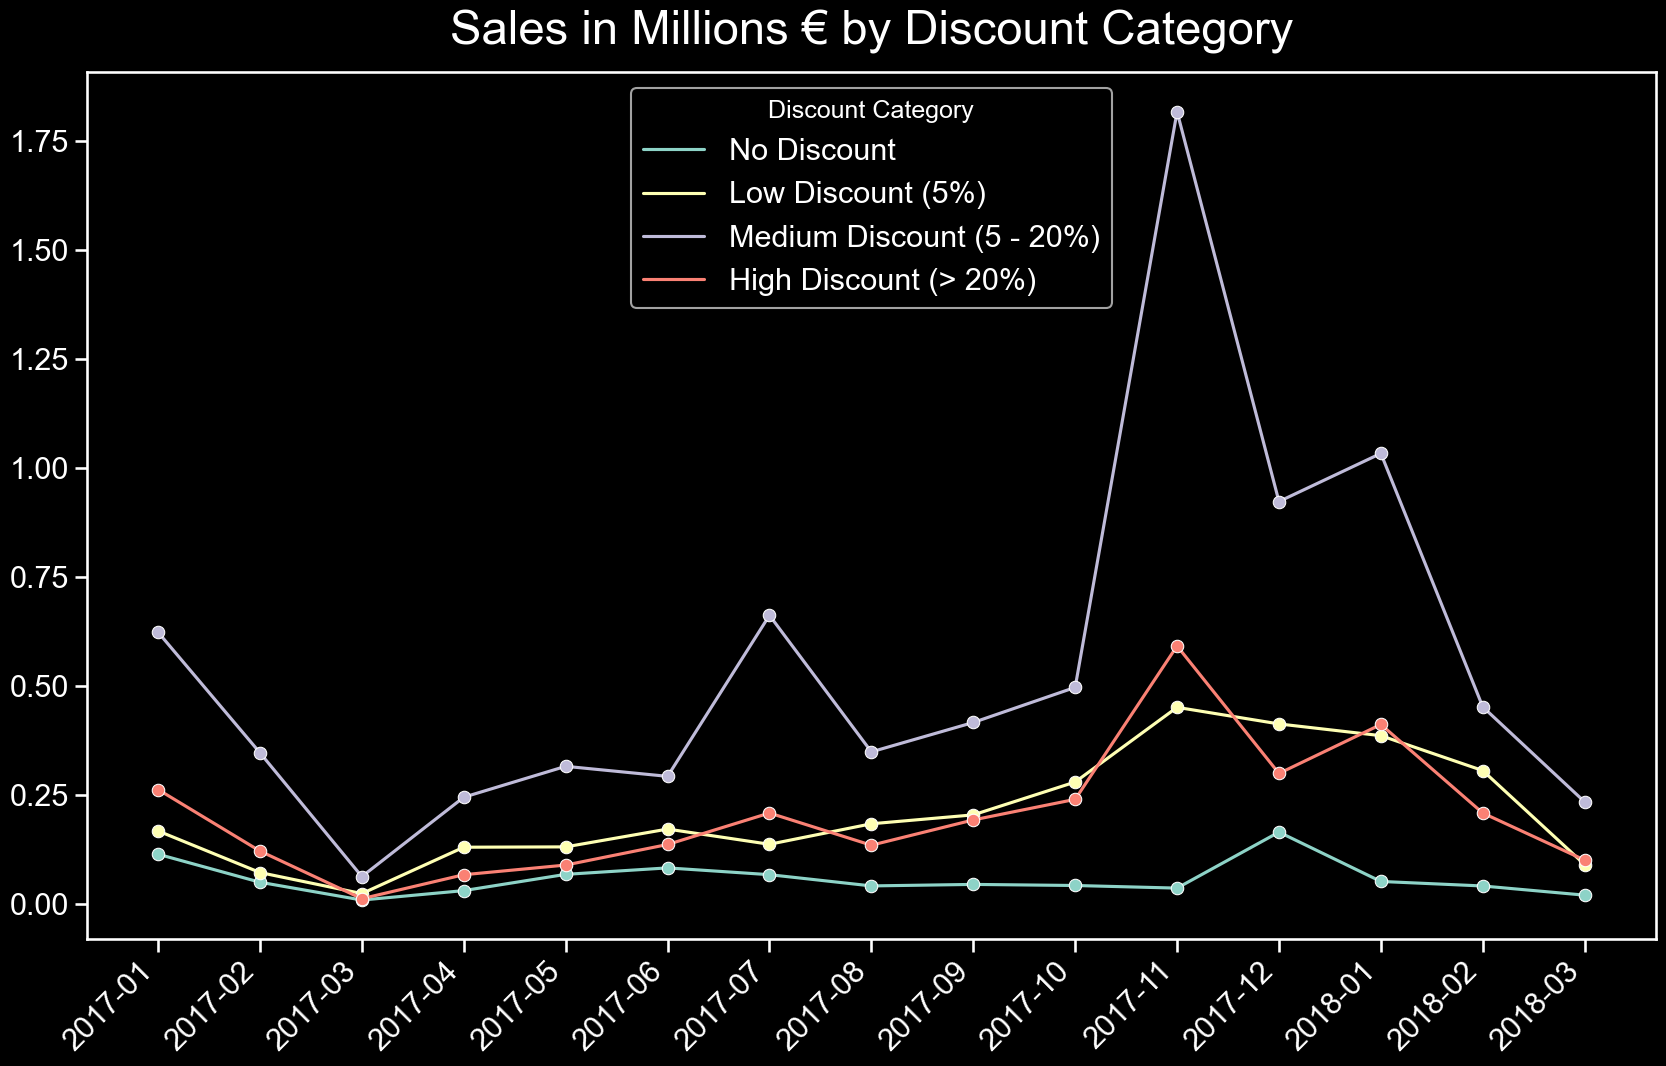

In [106]:
complete["month_year"] = complete["month_year"].astype(str) 

# Group by month and discount category, sum the total sales
sales_by_month_discount = complete.groupby(['month_year', 'discount_category'])['unit_price'].sum().reset_index()

# Convert sales to millions € for better visualization
sales_by_month_discount['order_total_millions'] = sales_by_month_discount['unit_price'] / 1_000_000

# Plot using Seaborn
plt.figure(figsize=(17, 11))
sns.lineplot(data=sales_by_month_discount, x='month_year', y='order_total_millions', hue='discount_category', marker='o')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Modify tick labels
plt.tick_params(axis="both", which="both", labelsize=22)

plt.xlabel('')
plt.ylabel('')
plt.title('Sales in Millions € by Discount Category', fontsize=34, pad=20)
# Adjust the legend position
plt.legend(title='Discount Category', fontsize=22, loc="upper center")
plt.tight_layout()
plt.show()

## Most Sold Discounted Products

In [111]:
# Collapse Macbooks into one category
complete.loc[(complete["category"] == "secondhandmac") | 
             (complete["category"] == "macbookair13"), 
             "category"] = "macbook"


# New dataframe consisting only of discounted products
discounted = complete.loc[complete["has_discount"] == True]

# Grouping of discounted df
discounted_group = discounted.groupby(["category"]).agg({"unit_price": "sum", "discount_percentage": "mean"}).sort_values("unit_price", ascending=False)
discounted_group = discounted_group.reset_index()

# Create column for average discount percentage of each category for both new dfs
discounted_group["discount_percentage"] = discounted_group["discount_percentage"].astype(int)

# Create column for percentage of total revenue of each category
total_rev = complete["unit_price"].sum() # Variable for total revenue
discounted_group["perc_of_rev"] = (discounted_group["unit_price"] * 100 / total_rev).astype(int)

In [112]:
# Create df for only top 5 categories
top5 = discounted_group.head(5).copy()

# Convert unit_price to millions
top5["unit_price"] = top5["unit_price"] / 1_000_000

In [113]:
top5

,category,unit_price,discount_percentage,perc_of_rev
0,macbook,3.107910,10,20
1,other,2.549368,25,16
2,imac,1.950961,12,12
3,externalhd,0.787878,17,5
4,monitor,0.641475,13,4


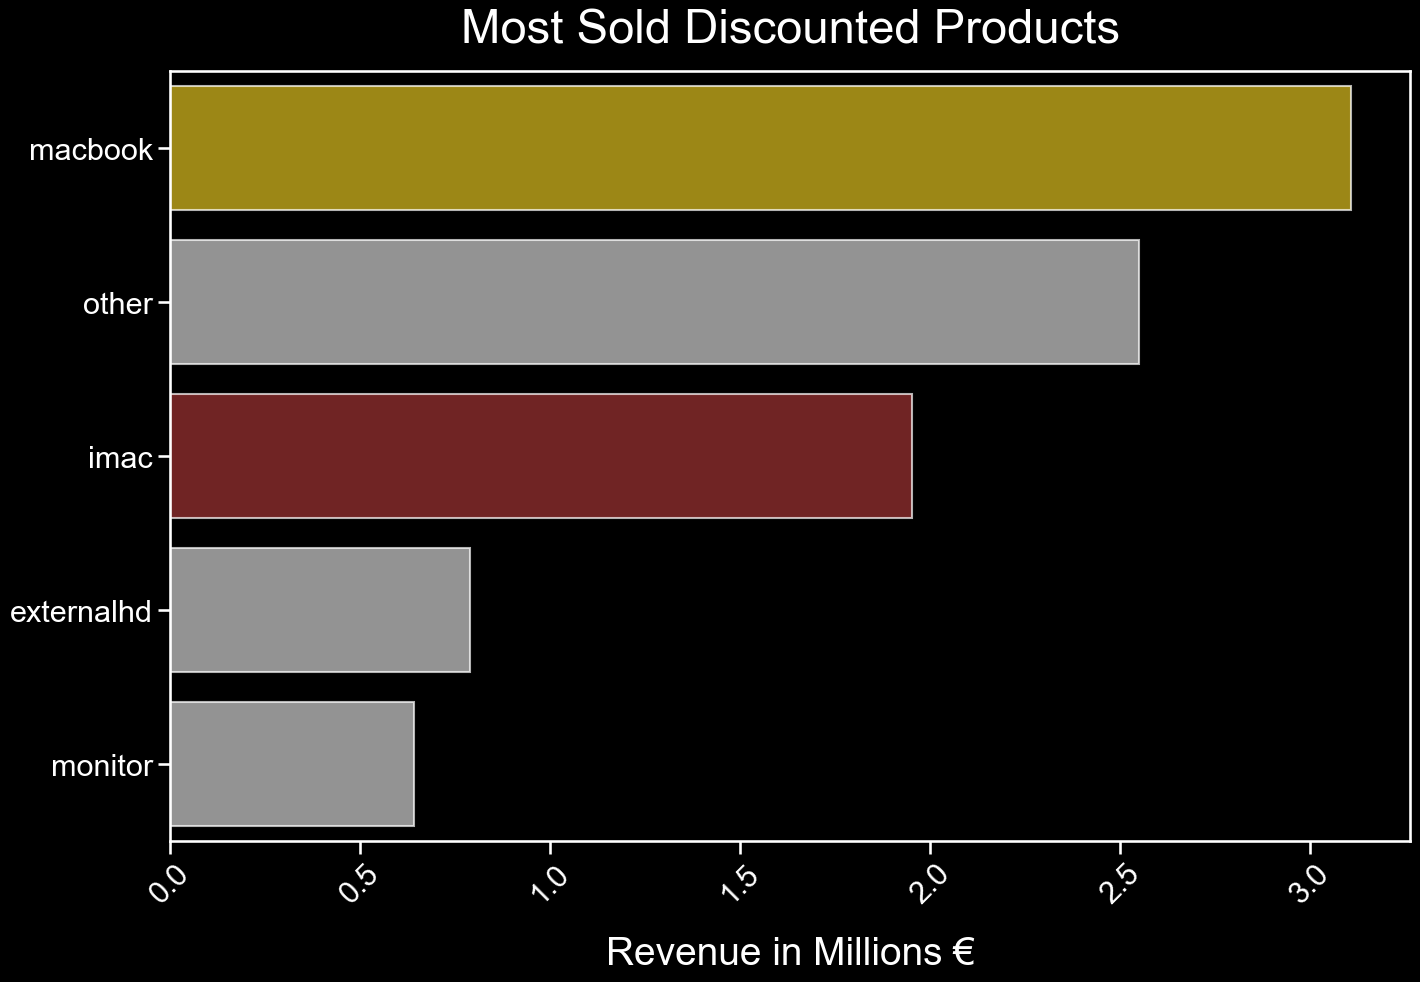

In [114]:
plt.figure(figsize =(16, 10))
custom_palette = ["gold", "lightgrey", "firebrick", "lightgrey", "lightgrey"]

sns.barplot(data=top5,
            x="unit_price",
            y="category",
            palette=custom_palette,
            alpha=0.7)

plt.xticks(rotation=45)
plt.xlabel("Revenue in Millions €", fontsize=28, labelpad=20)
plt.ylabel("")
plt.title("Most Sold Discounted Products", fontsize=34, pad=20)
plt.tick_params(which="both", axis="both", labelsize=22)